In [1]:
# project: p6
# submitter: ejhickey3
# partner: none
# hours: 9

In [2]:
import pandas as pd
import sqlite3
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

In [3]:
#Q1: How many counties are in Wisconsin?

wisco_df = gpd.read_file('counties.geojson')
len(wisco_df)

72

<AxesSubplot:>

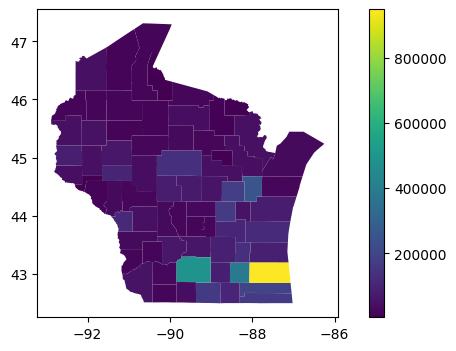

In [4]:
#Q2: What is the population of each county in WI?

wisco_df.plot(figsize=(8,4), column="POP100", legend=True, cmap="viridis")

In [5]:
conn = sqlite3.connect("counties_tracts.db")
pd.read_sql("""SELECT * FROM sqlite_master""", conn)

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [6]:
AREALAND = pd.read_sql("""SELECT AREALAND FROM counties""", conn)
wisco_df["AREALAND"] = AREALAND


In [7]:
 train, test = train_test_split(wisco_df, random_state=250, test_size=0.25)

In [8]:
#Q3: What are the counties in the test dataset?

list(test["NAME"])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [9]:
#Q4: How much variance in the POP100 can a LinearRegression 
#model explain based only on AREALAND?

model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.016720430179409274

In [10]:
(wisco_df[["AREALAND"]]/2590000)

,AREALAND
0,332.638509
1,1209.798483
2,793.067471
3,913.549260
4,233.017148
...,...
67,797.110421
68,900.876562
69,586.146825
70,1254.388587


In [11]:
#Q5: What is the predicted population of a county with 400 square miles of area, 
#according to the model?  #Land Area (Square Meters)

model = LinearRegression()
model.fit((train[["AREALAND"]]/2590000), train["POP100"])
y = model.predict((train[["AREALAND"]]/2590000))
predict_df = pd.DataFrame({"AREALAND": [400]})
predict_df["predicted population"] = model.predict(predict_df)
predict_df["predicted population"][0]

90000.07422783462

In [12]:
HU100 = pd.read_sql("""SELECT HU100, COUNTY FROM tracts""", conn)
COUNTY = pd.read_sql("""SELECT COUNTY FROM counties""", conn)
wisco_df["COUNTY"] = COUNTY
wisco_df = wisco_df.set_index("COUNTY")
HU100_dict = {}
for idx in range(len(HU100)):
    if  HU100["COUNTY"][idx] not in HU100_dict:
        HU100_dict[HU100["COUNTY"][idx]] = 0
    if HU100["COUNTY"][idx] in HU100_dict:
        HU100_dict[HU100["COUNTY"][idx]] += HU100["HU100"][idx]

In [13]:
HU100_sorted = {}
for idx in range(len(wisco_df)):
    for i in HU100_dict:
        if i == wisco_df.index[idx]:
            HU100_sorted[i] = HU100_dict[i]
        else:
            continue

HU100 = pd.DataFrame(pd.Series(HU100_sorted))
HU100.columns = ["HU100"]
wisco_df["HU100"] = HU100["HU100"]

In [14]:
 train, test = train_test_split(wisco_df, random_state=250, test_size=0.25)

In [15]:
#Q6: What are the counties in the test dataset?

list(test["NAME"])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [16]:
#Q7: What are the HU100 values for the counties in the test dataset?
county_HU100 = {}

for idx in range(len(test)):
    key = test["NAME"][idx] 
    val = test["HU100"][idx]
    county_HU100[key] = val

county_HU100

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [17]:
#Q8: How much variance in the POP100 can a LinearRegression model explain based only on HU100?

model = LinearRegression()
xcols = ["HU100"]
ycol = "POP100"

model.fit(train[xcols], train[ycol])
scores = cross_val_score(model, train[xcols], train[ycol])
scores.mean()

0.9739348181232653

In [18]:
#Q9: What is the standard deviation of the cross validation scores from Q8?

scores.std()

0.01693954236334351

In [19]:
#Q10: What is the formula relating POP100 and HU100?

intercept = round(model.intercept_, 2)
coeff = round(model.coef_[0], 2)
formula = f"POP100 = {coeff}*HU100 + {intercept}"
formula

'POP100 = 2.47*HU100 + -9276.89'

Text(COUNTY
009    104371
Name: HU100, dtype: int64, COUNTY
009    248007
Name: POP100, dtype: int64, 'Brown')

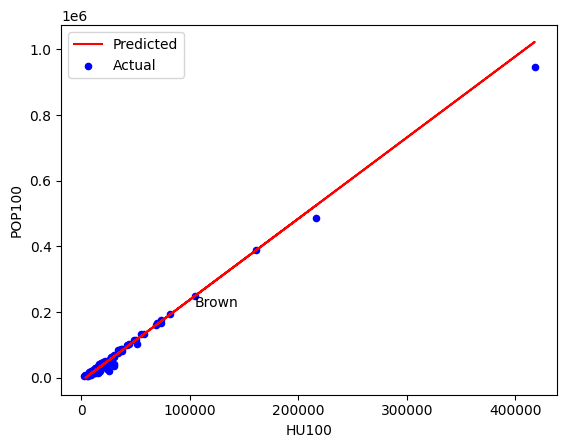

In [20]:
#Q11: What is the relationship between HU100 and POP100, visually?

model = LinearRegression()
xcols = ["HU100"]
ycol = "POP100"

model.fit(train[xcols], train[ycol])
# predict_df = pd.DataFrame({"HU100": range(0, 500000,  100000)})
test["Predicted"] = model.predict(test[['HU100']])
ax = test.plot.line(x="HU100", y="Predicted", color="r")
actual = wisco_df.plot.scatter(x="HU100", y="POP100", ax=ax, color="b", label = "Actual")
x = wisco_df[wisco_df['NAME'] == 'Brown County']["HU100"]
y = wisco_df[wisco_df['NAME'] == 'Brown County']["POP100"]
actual.text(x,y,'Brown',  ha="left", va="top")

In [21]:
#Q12: How many numbers in matrix A are between 3 and 6 (inclusive)?

A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

((6>= A)*(A>=3)).astype(int).sum()

8

In [22]:
from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

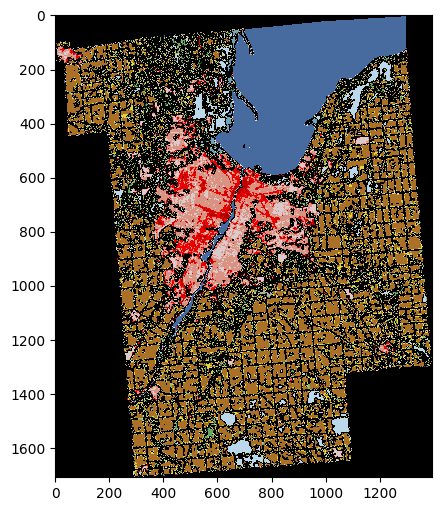

In [23]:
#Q13: How does Brown County look?

land = rasterio.open("zip://../p6/land.zip!wi.tif")
Brwn_Cnty = wisco_df[wisco_df["NAME"] == "Brown County"]
matrix, _ = mask(land, Brwn_Cnty.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)

In [24]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

In [25]:
#Q14: What portion of Brown County is "Open Water"?

(matrix==11).astype(int).sum()/(matrix != 0).astype(int).sum()

0.13797526789725206

In [26]:
cell_ctr = []
for cty in wisco_df["NAME"]:
    row = wisco_df[wisco_df["NAME"] == f"{cty}"]
    matrix, _ = mask(land, row.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    cell_ct = (matrix==90).astype(int).sum()
    cell_ctr.append(cell_ct)
    
cell_ctr = pd.Series(cell_ctr)
cell_ctr = pd.DataFrame(cell_ctr)
cell_ctr.columns = ["Woody Wetland Cells in County"]
cell_ctr["COUNTY"] = COUNTY
cell_ctr = cell_ctr.set_index("COUNTY")
wisco_df["Woody Wetland Cells in County"] = cell_ctr["Woody Wetland Cells in County"]

<AxesSubplot:xlabel='Woody Wetland Cells in County', ylabel='POP100'>

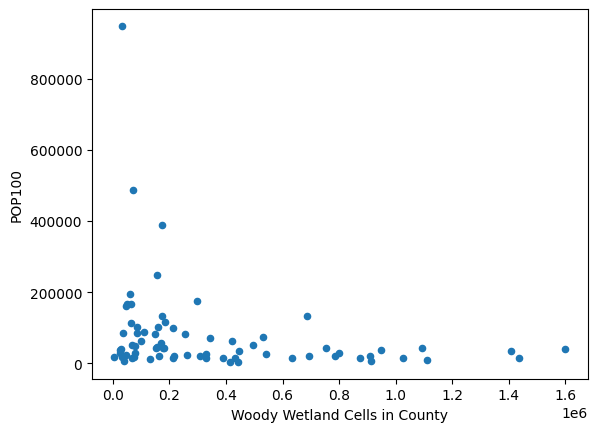

In [27]:
#Q15: What is the Relationship Between POP100 and ________________?
#woody_wetlands

wisco_df.plot(kind = 'scatter',
        x = 'Woody Wetland Cells in County',
        y = 'POP100',)

In [28]:
file = "tracts.shp"
tracts_df = gpd.read_file(file)

In [29]:
tracts_df

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02627 44.089..."
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15010 44.513..."
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53547 44.334..."
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.89338 44.678..."
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.05841 44.461..."
...,...,...,...
1537,55139003100,2046,"POLYGON ((-88.47454 44.19198, -88.47450 44.192..."
1538,55079017900,2879,"POLYGON ((-87.91064 42.99520, -87.91038 42.995..."
1539,55059000800,2763,"POLYGON ((-87.84574 42.60276, -87.84548 42.602..."
1540,55025013700,7107,"POLYGON ((-89.57788 42.98135, -89.57788 42.981..."


In [30]:
feature_tract_list = []
for cty in tracts_df["GEOID"]:
    data = {}
    row = tracts_df[tracts_df["GEOID"] == f"{cty}"]
    matrix, _ = mask(land, row.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    for key in land_use:
        code = land_use[key]
        tract_ct = (matrix==code).astype(int).sum()
        data[key] = tract_ct
    feature_tract_list.append(data)
    
feature_tract = pd.DataFrame(feature_tract_list)

In [31]:
tracts_df = pd.concat([tracts_df, feature_tract], axis=1, join='inner')

In [32]:
 train, test = train_test_split(tracts_df, random_state=320, test_size=0.25)

In [33]:
model = LinearRegression()
xcols = list(land_use.keys())
ycol = "POP100"

model.fit(train[xcols], train[ycol])
test["Predicted POP100"] = model.predict(test[xcols])
model.score(test[xcols], test[ycol])

0.44867285416657754

In [34]:
#ax = test.plot.line(x="", y="Predicted", color="r")

<AxesSubplot:>

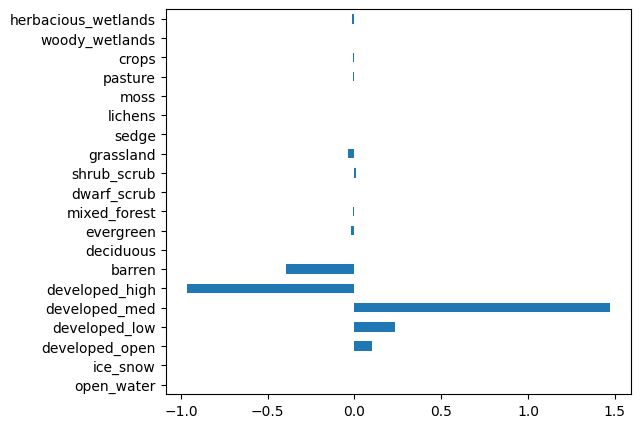

In [35]:
#Q16: What features does your model rely on most?

pd.Series(model.coef_, index=xcols).plot.barh(figsize=(6,5))

#This graph is showing what the model cares about in predicting the population,
#and basically what it had found to be the best predictors of population and 
#this means for our model that most of the land features have little effect on the 
#population prediction other than whether it is developed or not, and likely, taking most of 
#those features out of the model would create a similiar result

In [36]:
#MODEL 1:

train2 = train[["developed_med"]].copy()
train2["developed_med ^ 2"] = train2["developed_med"] ** 2
train2["developed_med ^ 3"] = train2["developed_med"] ** 3
train2["sqrt(developed_med)"] = train2["developed_med"] ** 0.5
pf = PolynomialFeatures(degree=4, include_bias=False)
pf.fit(train[["developed_med"]])
pd.DataFrame(pf.transform(train[["developed_med"]]), columns=pf.get_feature_names_out()).head()

m1 = Pipeline([
    ("pf", PolynomialFeatures()),
    ("lr", LinearRegression())
])
scores = cross_val_score(m1, train[["developed_med"]], train["POP100"], cv=10)
scores.mean()

0.4091327409282921

In [37]:
#MODEL 2:

m2 = LinearRegression()
xcols = ["developed_open",
            "developed_low",
            "developed_med",
            "developed_high",
            "barren"]
ycol = "POP100"

m2.fit(train[xcols], train[ycol])
test["Predicted POP100"] = m2.predict(test[xcols])
scores = cross_val_score(m2, train[xcols], train[ycol], cv=10)
scores.mean()


0.4419529418829651

In [38]:
#Q17: How does your recommended model score against the test dataset?

#I reccommend my second model because it is both more simplistic and produced higher scores
# while model one is ableto fit closer to the actual curves, it only looks at one factor 
#that may influence the prediction, but the second model looks at all of the ones that were 
#considered important by the linear regression using all of the variables availiable 

m2.fit(train[xcols], train[ycol])
m2.score(test[xcols], test[ycol])

0.3924129085891599